In [61]:
#CS 513: Knowledge Discovery and Data 
#Group Members: Danica Lacuesta, Joelle An, and Raj Rana 
#Author: Joelle An
#20015285
#"I pledge my honor that I have abided by the Stevens Honor System"
#Purpose: This project analyzes digital activity patterns to classify user stress levels and identify the behavioral features that most strongly impact predictive accuracy.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
# Import dataset
df = pd.read_csv("data/Digital_Stress_Classifier_preprocess.csv")

df.head()


,Age,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Happiness_Index(1-10),Stress_Binary,Gender_Female,Gender_Male,Gender_Other,Social_Media_Platform_Facebook,Social_Media_Platform_Instagram,Social_Media_Platform_LinkedIn,Social_Media_Platform_TikTok,Social_Media_Platform_X (Twitter),Social_Media_Platform_YouTube
0,1.110090,-1.427055,0.456182,-0.611571,1.832943,1.073037,1,0,1,0,1,0,0,0,0,0
1,-0.298363,-0.247258,0.456182,1.001936,0.406841,1.073037,1,0,0,1,0,0,1,0,0,0
2,-1.002590,1.109509,-0.203486,-1.149407,0.406841,-1.584773,1,0,0,1,0,0,0,0,0,1
3,0.305259,0.106681,0.456182,-1.149407,-1.019260,-0.255868,1,1,0,0,0,0,0,1,0,0
4,0.104052,0.873549,-1.522823,1.001936,-1.019260,-0.255868,1,1,0,0,0,0,0,0,1,0


In [64]:
X = df.drop(columns=['Stress_Binary']) 
y = df['Stress_Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

pipe = Pipeline([('scaler', scaler), ('knn', knn_model)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracy = pipe.score(X_test, y_test)
print(f"\nKNN Model Test Accuracy: {accuracy:.3f}")


KNN Model Test Accuracy: 0.812



Optimal K selected: 8


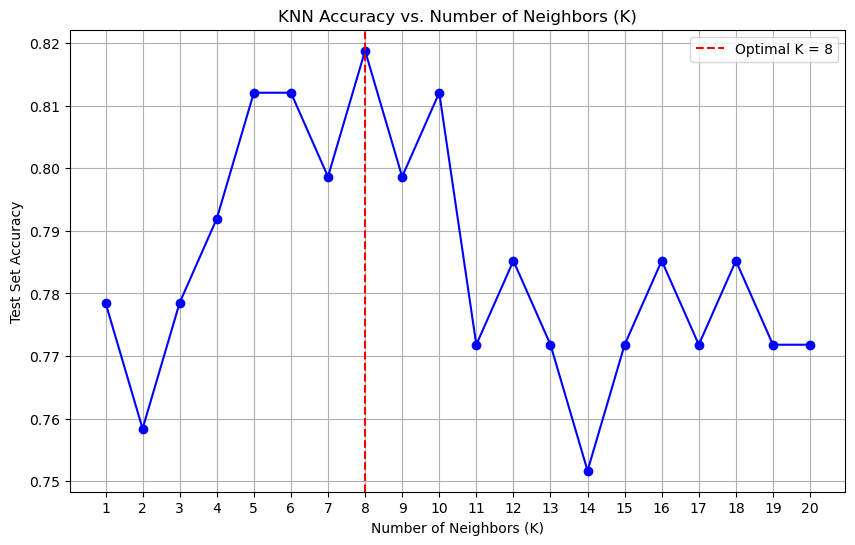

In [65]:
k_values = range(1, 21) # Test K from 1 to 20
test_accuracies = []
scaler = StandardScaler()

for k in k_values:
    # try:
        knn_pipeline = Pipeline([
            ('scaler', scaler),
            ('knn', KNeighborsClassifier(n_neighbors=k))
        ])
        knn_pipeline.fit(X_train, y_train)
    
        accuracy = knn_pipeline.score(X_test, y_test)
        test_accuracies.append(accuracy)

    # except Exception as e:
    #     print(f"🛑 Error encountered for K={k}: {e}")
    #     break

optimal_k = k_values[np.argmax(test_accuracies)]
print(f"\nOptimal K selected: {optimal_k}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, test_accuracies, marker='o', linestyle='-', color='blue')
plt.title('KNN Accuracy vs. Number of Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Test Set Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
plt.legend()
plt.savefig('knn_accuracy_vs_k.png')
plt.show() 
plt.close()


In [66]:
scaler = StandardScaler()
final_knn_pipeline = Pipeline([
    ('scaler', scaler),
    ('knn', KNeighborsClassifier(n_neighbors=optimal_k))
])
final_knn_pipeline.fit(X_train, y_train)
y_pred = final_knn_pipeline.predict(X_test)

report = classification_report(y_test, y_pred, target_names=['Not Stressed (1-5)', 'Stressed (6-10)'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
rows_to_drop = ['macro avg', 'weighted avg']
report_df = report_df.drop(rows_to_drop, errors='ignore')
report_df = report_df.drop(columns=['support'])
print("Classification Report:")
print(report_df.to_markdown(numalign="left", stralign="left", floatfmt=".3f"))

Classification Report:
|                    | precision   | recall   | f1-score   |
|:-------------------|:------------|:---------|:-----------|
| Not Stressed (1-5) | 0.722       | 0.371    | 0.491      |
| Stressed (6-10)    | 0.832       | 0.956    | 0.890      |
| accuracy           | 0.819       | 0.819    | 0.819      |


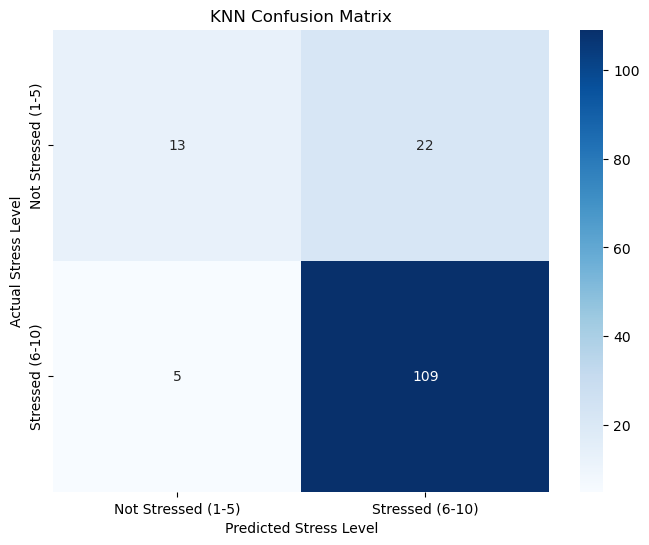

In [67]:
conf_matrix = confusion_matrix(y_test, y_pred)

class_names = ['Not Stressed (1-5)', 'Stressed (6-10)']

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='g', 
    cmap='Blues',
    xticklabels=class_names, 
    yticklabels=class_names,
    cbar=True
)
plt.xlabel('Predicted Stress Level')
plt.ylabel('Actual Stress Level')
plt.title('KNN Confusion Matrix')
plt.savefig('knn_confusion_matrix.png')
plt.show()
plt.close()

<Figure size 1500x800 with 0 Axes>

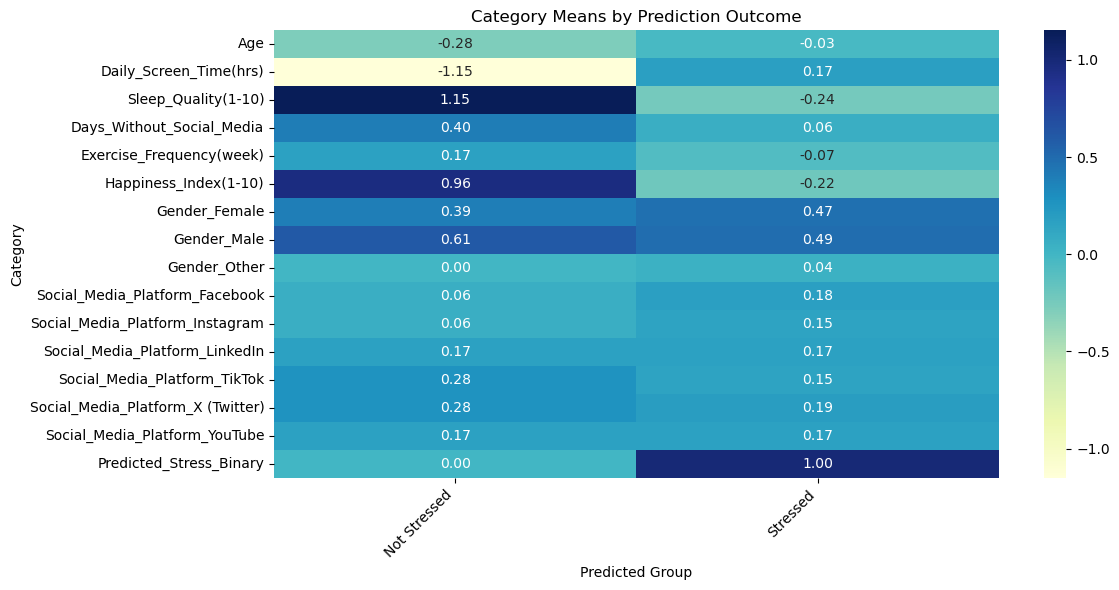

In [68]:
X_test_with_pred = X_test.copy()
X_test_with_pred['Predicted_Stress_Binary'] = y_pred

stress_map = {0: 'Not Stressed', 1: 'Stressed'}
X_test_with_pred['Prediction_Group'] = X_test_with_pred['Predicted_Stress_Binary'].map(stress_map)

feature_means = X_test_with_pred.groupby('Prediction_Group').mean()

plt.figure(figsize=(15, 8))
num_means_T = feature_means[numerical_cols].transpose()

# for i, col in enumerate(numerical_cols):
#     plt.subplot(2, 3, i + 1)
#     num_means_T.loc[col].plot(kind='bar', color=['skyblue', 'lightcoral'])
#     plt.title(f'Mean {col.replace("_", " ")}', fontsize=10)
#     plt.xlabel('Predicted Group')
#     plt.ylabel('Mean Value')
#     plt.xticks(rotation=0)

# plt.tight_layout()
# plt.suptitle('Mean Numerical Features by Predicted Stress Group', y=1.02, fontsize=16)
# plt.savefig('numerical_feature_means_by_prediction.png')
# plt.show()
# plt.close()

# plt.figure(figsize=(15, 8))
# ohe_means_T = feature_means[ohe_cols].transpose()

# gender_cols = [col for col in ohe_cols if 'Gender_' in col]
# platform_cols = [col for col in ohe_cols if 'Social_Media_Platform_' in col]

# plt.subplot(1, 2, 1)
# gender_means_T = ohe_means_T.loc[gender_cols]
# gender_means_T.index = [i.replace('Gender_', '') for i in gender_means_T.index] # Clean labels
# gender_means_T.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightcoral'])
# plt.title('Mean Gender Proportions', fontsize=12)
# plt.xlabel('Gender Category')
# plt.ylabel('Proportion')
# plt.xticks(rotation=45, ha='right')
# plt.legend(title='Predicted Group')

# plt.subplot(1, 2, 2)
# platform_means_T = ohe_means_T.loc[platform_cols]
# platform_means_T.index = [i.replace('Social_Media_Platform_', '') for i in platform_means_T.index] # Clean labels
# platform_means_T.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightcoral'])
# plt.title('Mean Social Media Platform Proportions', fontsize=12)
# plt.xlabel('Social Media Platform')
# plt.ylabel('Proportion')
# plt.xticks(rotation=45, ha='right')
# plt.legend(title='Predicted Group')

# plt.tight_layout()
# plt.suptitle('Mean Proportional Features (OHE) by Predicted Stress Group', y=1.02, fontsize=16)
# plt.savefig('ohe_feature_means_by_prediction.png')
# plt.show()
# plt.close()

plt.figure(figsize=(12, 6))

summary_df = feature_means.copy()
sns.heatmap(summary_df.T, annot=True, fmt=".2f", cmap="YlGnBu") 
plt.title("Category Means by Prediction Outcome")
plt.xlabel("Predicted Group")
plt.ylabel("Category")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0) 
plt.tight_layout()
plt.savefig('category_means_heatmap.png')
plt.show()
plt.close()